# Data Preprocess

- 1 Label samples <br>
> 1.1 Label by user, and fit LR to get high coefficient features <br>
> 1.2 Label by sentence, for future use of find containing sentences <br>

- 2 Get paraphrase <br>
> 2.1 Get all paraphrase pairs <br>
> 2.2 Limit paraphrase pairs by equal_score <br>
> 2.3 Limit paraphrase with at least one has high coef <br>

- 3 Map candidate word to containing instances <br>
> 3.1 Get word frequency, ratio, and remove low frequent words <br>
- 4 Map word pair to containing sentences <br>

In [1]:
import pickle, csv, time, re, random
import pandas as pd
import numpy as np
from collections import Counter
from scipy.stats import zscore
from nltk import pos_tag, word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn import preprocessing
import nltk
from collections import defaultdict, Counter
from nltk.corpus import brown
from nltk.corpus import wordnet as wn
from nltk.stem import SnowballStemmer, WordNetLemmatizer
snowball_stemmer = SnowballStemmer("english")

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_path = '/data/2/zwang/2018_S_WordTreatment/'
airbnb_path = '/data/2/zwang/2018_S_WordTreatment/V2_airbnb/'
tw_path = '/data/2/zwang/2018_S_WordTreatment/V2_twitter/'
yp_path = '/data/2/zwang/2018_S_WordTreatment/V2_yelp/'

## 1. Label samples <br>
- 1.1 label by user/hood, fit LR to get high coefficient word features.
- 1.2 label by sentence, for treatment effect estimation.

In [7]:
def mark_postag(text):
    """
    Mark proper noun (place names, people's names), numbers.
    """
    mark_sent = ''
    for tag_item in pos_tag(text.split()):
        if(tag_item[1]=='NNP'):
            mark_sent += "_NNP_ "
        elif(tag_item[1]=='CD'):
            mark_sent += "_NUMBER_ "
        else:
            mark_sent += tag_item[0]+' '
    return mark_sent

In [11]:
def label_by_view(data_file, label_byview_file,label_byview_markedfile):
    """
    This function only applies for airbnb data.
    Each neighborhood overview is an instance, label it by comparing city_crime and hood_crime.
    """
    
    usertext_list = []
    marked_usertext_list = []
    label_list = []
    data_pd = pd.DataFrame(pickle.load(open(data_file,"rb")))
    for idx,row in data_pd.iterrows():
        if(idx % 20000 == 0):
            print(idx)
        if(float(row.hood_crime) < float(row.city_crime)):
            lb = 'pos'
        elif(float(row.hood_crime) >= float(row.city_crime)):
            lb = 'neg'
        
        usertext_list.append(row.hood_overviews)
        marked_usertext_list.append(mark_postag(row.hood_overviews))
        label_list.append(lb)
    
    pickle.dump({'user_content':usertext_list,'user_lb':label_list},open(label_byview_file,'wb'))
    pickle.dump({'marked_user_content':marked_usertext_list,'user_lb':label_list},open(label_byview_markedfile,'wb'))
    print("Distribution by neighborhood overview:\n",Counter(label_list))

In [12]:
data_file = airbnb_path + '0_Data/city_hood_byview.pickle'
label_byview_file = airbnb_path + '1_Process/airbnb_label_byview.pickle'
label_byview_markedfile = airbnb_path + '1_Process/airbnb_label_byview_posmarked.pickle'
start = time.time()
label_by_view(data_file, label_byview_file, label_byview_markedfile)
end = time.time()
print("Run time: %.1f minutes" % float((end-start)/60))

0
20000
40000
60000
80000
Distribution by neighborhood overview:
 Counter({'pos': 81767, 'neg': 17853})


TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [33]:
data_pd = pd.DataFrame(pickle.load(open(label_byview_file,'rb')))
data_pd.shape

(99620, 2)

In [36]:
data_pd.head()

,user_content,user_lb
0,Cobble _NNP_ is a wonderful neighborhood with ...,pos
1,I love everything about the neighborhood . It ...,pos
2,Squeezed between the similarly charming ( and ...,pos
3,An ideal spot . _NUMBER_ of the best neighborh...,pos
4,"We are located on _NNP_ _NNP_ , and are in wal...",pos


In [37]:
data_pd.iloc[0].user_content

'Cobble _NNP_ is a wonderful neighborhood with so many great restaurants and amenities . This neighborhood was Italian in decades past and is close to the old shipping docks . Now _NNP_ _NNP_ and _NNP_ _NNP_ serve food from all over the world . The Invisible _NNP_ art gallery , housed in an old leather factory , is nearby on _NNP_ _NNP_ . '

In [13]:
def label_by_user(content_file,label_file,label_byuser_file,label_byuser_markedfile):
    """
    This function only applies for twitter and yelp gender data.
    Each line is an user, take as an instance, label it by gender.
    """
    usertext_list = []
    marked_usertext_list = []
    i=0
    with open(content_file,'r') as dataf:
        for line in dataf:
            i += 1
            if(i % 10000 == 0):
                print(i)
            text = re.findall('<s> (.+) </s>',line.strip())[0]
            usertext_list.append(text)
            marked_usertext_list.append(mark_postag(text))
    dataf.close()
    
    label_list = []
    with open(label_file,'r') as lbf:
        for line in lbf:
            if(line.strip() == 'M'):
                label_list.append('pos')
            elif(line.strip() == 'F'):
                label_list.append('neg')
            else:
                print('error')
                
    lbf.close()
    
    pickle.dump({'user_content':usertext_list,'user_lb':label_list},open(label_byuser_file,'wb'))
    pickle.dump({'marked_user_content':marked_usertext_list,'user_lb':label_list},open(label_byuser_markedfile,'wb'))
    
    print("Distribution by user:\n",Counter(label_list))

In [ ]:
start = time.time()
label_by_user(tw_path+'0_Data/tw.text',tw_path+'0_Data/tw.labels',
              label_byuser_file=tw_path+'1_Process/tw_label_byuser.pickle',
              label_byuser_markedfile=tw_path+'1_Process/tw_label_byuser_posmarked.pickle')
end = time.time()
print("Run time: %.1f minutes for twitter" % float((end-start)/60))

10000
20000
30000
40000
50000
60000
70000
80000
90000
Distribution by user:
 Counter({'neg': 47298, 'pos': 47297})
Run time: 33.5 minutes for twitter


In [30]:
print("Run time: %.1f minutes for twitter" % float((end-start)/60))

Run time: 52.6 minutes for twitter


In [ ]:
start = time.time()
label_by_user(yp_path+'0_Data/yp.text',yp_path+'0_Data/yp.labels',
              label_byuser_file=yp_path+'1_Process/yp_label_byuser.pickle',
              label_byuser_markedfile=yp_path+'1_Process/yp_label_byuser_posmarked.pickle')
end = time.time()
print("Run time: %.1f minutes for yelp" % float((end-start)/60))

10000
20000
30000
40000
Distribution by user:
 Counter({'neg': 21650, 'pos': 21649})
Run time: 22.2 minutes for yelp


In [32]:
start = time.time()
label_by_user(yp_path+'0_Data/yp.text',yp_path+'0_Data/yp.labels',
              label_byuser_file=yp_path+'1_Process/yp_label_byuser.pickle',
              label_byuser_markedfile=yp_path+'1_Process/yp_label_byuser_posmarked.pickle')
end = time.time()
print("Run time: %.1f minutes for yelp" % float((end-start)/60))

10000
20000
30000
40000
Distribution by user:
 Counter({'neg': 21650, 'pos': 21649})
Run time: 26.1 minutes for yelp


In [42]:
data_pd = pd.DataFrame(pickle.load(open(yp_path+'1_Process/yp_label_byuser.pickle','rb')))
data_pd.shape

(43299, 2)

In [43]:
data_pd.head()

,user_content,user_lb
0,"Good service , not too busy _NNP_ morning . _N...",pos
1,_NNP_ 's was _NUMBER_ of our favorite Italian ...,pos
2,Good food . Ok but not special . Got the hot r...,pos
3,Horrible service . They messed up my order on ...,pos
4,There are multiple reasons for which I could h...,pos


In [72]:
data_pd.user_lb.values[1000:1005]

array(['pos', 'pos', 'pos', 'pos', 'pos'], dtype=object)

#### Fit LogisiticRegression to:
> get the most important word feature that relate with each class <br>
> limit candidate vocabulary for calculating paraphrase pairs <br>
> find high coefficient word features <br>
> Fit on user level, each user as an instance, get obvious gender features. <br>
> Fit on sentence level, each sentence as an instance, doesn't get obvious gender features.<br>

In [13]:
def fit_user_LR(labeled_file,vocab):
    data_pd = pd.DataFrame(pickle.load(open(labeled_file,'rb')))
    if(vocab):
        my_vocab = list(set(pd.read_csv(vocab).word.values))
        vec = TfidfVectorizer(vocabulary=my_vocab)
    else:
        vec = TfidfVectorizer()
    X_data = vec.fit_transform(data_pd.user_content.values)
    y_label = data_pd.user_lb.values
    
    lr_clf = LogisticRegression(random_state=42,n_jobs=-1)
    lr_clf.fit(X_data,y_label)
    print(Counter(y_label))
    feature_ct = np.array(np.sum(X_data,axis=0))[0]
    le = preprocessing.LabelEncoder()
    print('5-fold cross validation roc_auc:',float('{:.3f}'.format(np.mean(cross_val_score(lr_clf, X_data, le.fit(['pos','neg']).transform(y_label), cv=5, scoring='roc_auc')))))
    return vec,lr_clf, feature_ct

In [44]:
def write_word_coef(ct_vec,lr_clf,coef_thresh,wd_coef_file):
    """
    Write coef value as well as zscore scaled coef value
    """
    feats = ct_vec.get_feature_names()
    word_info = []
    coef_info = []
    for idx in lr_clf.coef_[0].argsort()[::-1]:
        if(abs(lr_clf.coef_[0][idx]) >= coef_thresh):
            word_info.append(feats[idx])
            coef_info.append(lr_clf.coef_[0][idx])
        else:
            continue
    
    coef_pd = pd.DataFrame({'word':word_info,'coef':coef_info})
    coef_pd['scaled_coef'] = zscore(coef_pd['coef'])
    coef_pd.to_csv(wd_coef_file,columns=['word','coef','scaled_coef'],index=False)
    print("%d out of %d word features remained" % (len(word_info),len(feats)))

- Plot coef disctribution before and after zscore

(array([  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          2.00000000e+00,   1.00000000e+00,   3.00000000e+00,
          1.00000000e+00,   3.00000000e+00,   3.00000000e+00,
          2.00000000e+00,   5.00000000e+00,   7.00000000e+00,
          8.00000000e+00,   2.00000000e+01,   6.20000000e+01,
          1.32000000e+02,   4.52000000e+02,   1.70100000e+03,
          2.70330000e+04,   6.19850000e+04,   2.02300000e+03,
          4.81000000e+02,   1.47000000e+02,   5.80000000e+01,
        

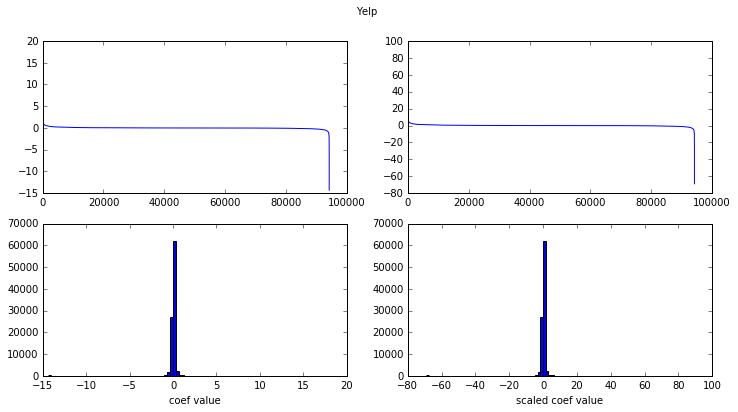

In [84]:
coef_pd = pd.read_csv(yp_path+'1_Process/word_coef00.csv',index_col=False)

fig,axs = plt.subplots(2,2,figsize=(12,6))
fig.suptitle("Yelp")
axs[1][0].set_xlabel('coef value')
axs[1][1].set_xlabel('scaled coef value')
axs[0][0].plot(coef_pd['coef'])
axs[0][1].plot(coef_pd['scaled_coef'])
axs[1][0].hist(coef_pd['coef'],bins=100)
axs[1][1].hist(coef_pd['scaled_coef'],bins=100)

,word,coef,scaled_coef
0,beach,6.555917,6.820242
1,village,5.651846,5.873819
2,ocean,4.874172,5.059714
3,lincoln,4.741565,4.920895
4,square,4.414141,4.578133


> Fit LR for twitter data, take abs(coef)>1 as high coef feature according to hist plot

In [60]:
print("Twitter:")
tw_ct_vec, tw_lr_clf, tw_feature_ct = fit_user_LR(tw_path+'1_Process/tw_label_byuser.pickle',vocab=False)
write_word_coef(tw_ct_vec,tw_lr_clf,coef_thresh=0.0,wd_coef_file=tw_path+'1_Process/word_coef00.csv')

Twitter:
Counter({'neg': 47298, 'pos': 47297})
5-fold cross validation roc_auc: 0.773
327132 out of 327132 word features remained


In [7]:
ct_vec, lr_clf, feature_ct = fit_user_LR(tw_path+'1_Process/tw_label_byuser.pickle',vocab=False)
write_word_coef(ct_vec,lr_clf,coef_thresh=0.5,wd_coef_file=tw_path+'1_Process/word_coef05.csv')

Counter({'neg': 47298, 'pos': 47297})
0.741772577529
235279 word features in total, and limit vocabulary to 4087


In [8]:
ct_vec, lr_clf, feature_ct = fit_user_LR(tw_path+'1_Process/tw_label_byuser.pickle',vocab=False)
write_word_coef(ct_vec,lr_clf,coef_thresh=0.1,wd_coef_file=tw_path+'1_Process/word_coef01.csv')

Counter({'neg': 47298, 'pos': 47297})
0.741772577529
235279 word features in total, and limit vocabulary to 48208


In [9]:
n = 0
for idx in lr_clf.coef_[0].argsort()[::-1]:
    if(abs(lr_clf.coef_[0][idx])>1):
        n += 1
print(n)

916


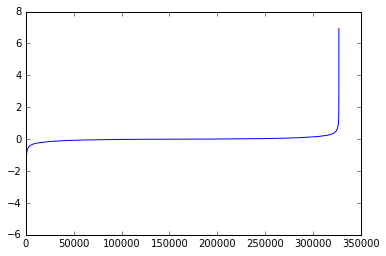

In [61]:
plt.plot(sorted(tw_lr_clf.coef_[0]))

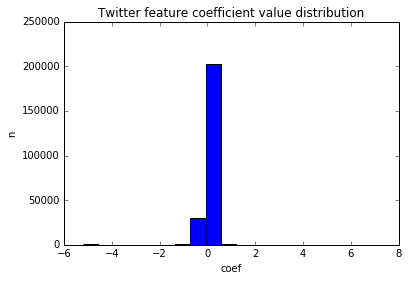

In [83]:
plt.hist(tw_lr_clf.coef_[0],bins=20)
plt.title("Twitter feature coefficient value distribution")
plt.xlabel("coef")
plt.ylabel("n")

In [84]:
feats = ct_vec.get_feature_names()
for idx in lr_clf.coef_[0].argsort()[::-1][:20]:
    print("%d \t %.3f \t %s" % (feature_ct[idx], lr_clf.coef_[0][idx], feats[idx]))

125 	 7.572 	 bro
52 	 5.527 	 girlfriend
107 	 5.063 	 dude
60 	 4.898 	 wife
98 	 4.194 	 nigga
272 	 4.085 	 man
30 	 3.951 	 pussy
65 	 3.445 	 football
53 	 3.384 	 gay
31 	 3.238 	 homie
25 	 3.212 	 bros
118 	 2.924 	 hit
26 	 2.916 	 dope
26 	 2.904 	 league
44 	 2.867 	 niggas
229 	 2.819 	 fuck
23 	 2.813 	 bud
275 	 2.809 	 game
167 	 2.779 	 drinking
123 	 2.765 	 team


In [85]:
feats = ct_vec.get_feature_names()
for idx in lr_clf.coef_[0].argsort()[::1][:20]:
    print("%d \t %.3f \t %s" % (feature_ct[idx], lr_clf.coef_[0][idx], feats[idx]))

84 	 -5.175 	 boyfriend
138 	 -4.887 	 hair
34 	 -4.379 	 husband
38 	 -4.033 	 obsessed
101 	 -3.952 	 shopping
97 	 -3.808 	 omg
1166 	 -3.796 	 so
913 	 -3.744 	 love
78 	 -3.687 	 yay
63 	 -3.646 	 boo
292 	 -3.645 	 girl
24 	 -3.527 	 hubby
58 	 -3.507 	 ugh
170 	 -3.483 	 such
121 	 -3.414 	 seriously
2334 	 -3.381 	 my
73 	 -3.096 	 loved
46 	 -3.081 	 tan
29 	 -3.076 	 bestie
60 	 -3.035 	 cry


> Fit LR for yelp data, take abs(coef)>1 as high coef feature according to hist plot

In [46]:
print("Yelp:")
ct_vec, lr_clf, feature_ct = fit_user_LR(yp_path+'1_Process/yp_label_byuser.pickle',vocab=False)
write_word_coef(ct_vec,lr_clf,coef_thresh=0.0,wd_coef_file=yp_path+'1_Process/word_coef00.csv')

Yelp:
Counter({'neg': 21650, 'pos': 21649})
5-fold cross validation roc_auc: 0.815
94176 out of 94176 word features remained


In [100]:
ct_vec, lr_clf, feature_ct = fit_user_LR(yp_path+'1_Process/yp_label_byuser.pickle',vocab=False)
write_word_coef(ct_vec,lr_clf,coef_thresh=0.5,wd_coef_file=yp_path+'1_Process/word_coef05.csv')

Counter({'neg': 21650, 'pos': 21649})
[ 0.81321598  0.81833478  0.81671549  0.80110943  0.80311616]
71097 word features in total, and limit vocabulary to 2264


In [12]:
ct_vec, lr_clf, feature_ct = fit_user_LR(yp_path+'1_Process/yp_label_byuser.pickle',vocab=False)
write_word_coef(ct_vec,lr_clf,coef_thresh=0.1,wd_coef_file=yp_path+'1_Process/word_coef01.csv')

Counter({'neg': 21650, 'pos': 21649})
0.810498365162
71097 word features in total, and limit vocabulary to 17512


In [102]:
n = 0
for idx in lr_clf.coef_[0].argsort()[::-1]:
    if(abs(lr_clf.coef_[0][idx])>1):
        n += 1
print(n)

493


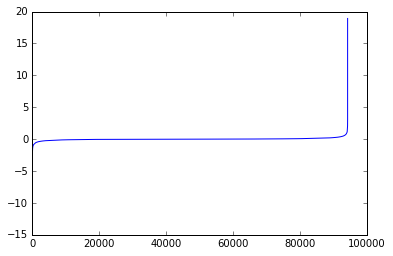

In [22]:
plt.plot(sorted(lr_clf.coef_[0]))

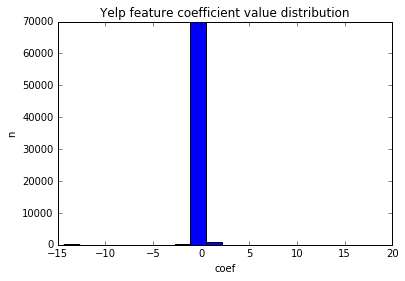

In [88]:
plt.hist(lr_clf.coef_[0],bins=20)
plt.title("Yelp feature coefficient value distribution")
plt.xlabel("coef")
plt.ylabel("n")

In [89]:
feats = ct_vec.get_feature_names()
for idx in lr_clf.coef_[0].argsort()[::-1][:20]:
    print("%d \t %.3f \t %s" % (feature_ct[idx], lr_clf.coef_[0][idx], feats[idx]))

212 	 18.658 	 wife
64 	 8.513 	 girlfriend
74 	 3.066 	 notch
556 	 3.047 	 some
14 	 2.896 	 bachelor
64 	 2.746 	 joint
59 	 2.744 	 solid
19 	 2.591 	 partner
17 	 2.514 	 buddy
55 	 2.458 	 steaks
171 	 2.293 	 cool
13 	 2.236 	 gf
84 	 2.227 	 showed
59 	 2.072 	 desert
1304 	 2.055 	 good
38 	 2.019 	 damn
1329 	 2.001 	 place
170 	 1.994 	 quite
106 	 1.949 	 might
123 	 1.895 	 average


In [90]:
feats = ct_vec.get_feature_names()
for idx in lr_clf.coef_[0].argsort()[::1][:20]:
    print("%d \t %.3f \t %s" % (feature_ct[idx], lr_clf.coef_[0][idx], feats[idx]))

234 	 -14.317 	 husband
104 	 -8.475 	 boyfriend
131 	 -5.438 	 yummy
574 	 -5.244 	 love
1198 	 -4.934 	 so
46 	 -4.851 	 delish
79 	 -4.646 	 fabulous
29 	 -4.462 	 hubby
64 	 -4.242 	 cute
22 	 -3.801 	 bf
261 	 -3.761 	 loved
78 	 -3.689 	 excited
507 	 -3.640 	 delicious
62 	 -3.565 	 yum
757 	 -3.489 	 rrb
69 	 -3.372 	 lovely
146 	 -3.261 	 beautiful
83 	 -2.972 	 die
32 	 -2.923 	 gorgeous
514 	 -2.856 	 because


> Fit LR Airbnb data, limit vocabulary on common words to eliminate neighbor/city specific features, take abs(coef)>0.2 as high coef feature according to hist plot

In [47]:
print('Airbnb:')
ct_vec, lr_clf, feature_ct = fit_user_LR(airbnb_path+'1_Process/airbnb_label_byview.pickle',
                                              vocab=airbnb_path+'0_Data/common_wds.csv')
write_word_coef(ct_vec,lr_clf,coef_thresh=0.0,wd_coef_file=airbnb_path+'1_Process/word_coef00.csv')

Airbnb:
Counter({'pos': 81767, 'neg': 17853})
5-fold cross validation roc_auc: 0.602
1550 out of 1550 word features remained


In [106]:
ct_vec, lr_clf, feature_ct = fit_user_LR(airbnb_path+'1_Process/airbnb_label_byview.pickle',
                                              vocab=airbnb_path+'0_Data/common_wds.csv')
write_word_coef(ct_vec,lr_clf,coef_thresh=0.0,wd_coef_file=airbnb_path+'1_Process/word_coef.csv')

Counter({'pos': 81767, 'neg': 17853})
[ 0.58147057  0.6311771   0.57505641  0.61886364  0.54138032]
1550 word features in total, and limit vocabulary to 1549


In [109]:
n = 0
for idx in lr_clf.coef_[0].argsort()[::-1]:
    if(abs(lr_clf.coef_[0][idx])>0.5):
        n += 1
print(n)

739


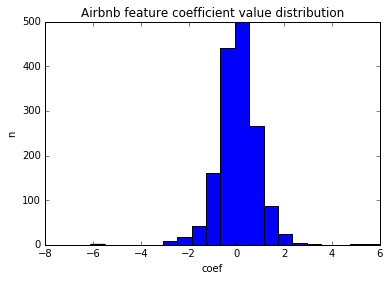

In [94]:
plt.hist(lr_clf.coef_[0],bins=20)
plt.title("Airbnb feature coefficient value distribution")
plt.xlabel("coef")
plt.ylabel("n")

In [95]:
feats = ct_vec.get_feature_names()
for idx in lr_clf.coef_[0].argsort()[::-1][:20]:
    print("%d \t %.3f \t %s" % (feature_ct[idx], lr_clf.coef_[0][idx], feats[idx]))

1347 	 5.949 	 beach
287 	 5.025 	 ocean
414 	 3.008 	 village
331 	 2.813 	 high
283 	 2.453 	 architecture
81 	 2.446 	 flat
184 	 2.324 	 desirable
90 	 2.265 	 bohemian
183 	 2.242 	 waterfront
49 	 2.181 	 greek
4167 	 2.120 	 restaurants
40 	 2.109 	 co
268 	 2.070 	 hill
89 	 2.059 	 nicest
77 	 2.032 	 foodie
252 	 2.021 	 organic
87 	 2.018 	 bookstores
82 	 1.953 	 mountain
57 	 1.900 	 games
127 	 1.885 	 laid


In [96]:
feats = ct_vec.get_feature_names()
for idx in lr_clf.coef_[0].argsort()[::1][:20]:
    print("%d \t %.3f \t %s" % (feature_ct[idx], lr_clf.coef_[0][idx], feats[idx]))

156 	 -6.088 	 spanish
162 	 -2.961 	 mexican
108 	 -2.854 	 nightclubs
504 	 -2.828 	 clubs
157 	 -2.771 	 working
178 	 -2.692 	 metro
123 	 -2.642 	 blvd
802 	 -2.595 	 art
41 	 -2.499 	 predominantly
33 	 -2.379 	 tapas
121 	 -2.368 	 artist
39 	 -2.186 	 restored
345 	 -2.177 	 studios
69 	 -2.172 	 target
124 	 -2.165 	 strip
34 	 -2.156 	 twenty
651 	 -2.123 	 galleries
31 	 -2.093 	 branch
116 	 -2.080 	 dance
147 	 -2.043 	 gyms


### 2. Get paraphrase pairs
> remove those has same word base using stem

In [116]:
def get_paraphrase(vocab_file,wd_para_file):
    """
    for each word, get its paraphrases, and select those exist in the corpus vocabulary to match a pair.
    3 possible cases: 1) get a list of paraphrases, and select those in the limited vocabulary;
                      2) get a list of paraphrases, but no paraphrase exists in the limited vocabulary; 
                      3) not in paraphrase vocabulary, so no paraphrase being found; 
    """
    my_vocab = pd.read_csv(open(vocab_file)).word.values
    
    ppdb = pd.read_csv(open('/data/2/zwang/2018_S_WordTreatment/V0_airbnb/1_Data/Crime/ppdb_xxxl.csv'))
    ppdb_vocab = Counter(ppdb.source.values)
    
    wd_para_info = []
    not_in_vocab = []
    no_para = []
    i=0
    
    for wd in my_vocab:
        i += 1
        if(i%100 == 0):
            print(i)
        if(wd in ppdb_vocab):
            para_pd = ppdb[(ppdb['source'] == wd)]
            for tar_wd in para_pd.target.values:
                if((tar_wd in my_vocab) and (tar_wd != wd)):
                    if({'source':tar_wd,'target':wd,'score':para_pd[para_pd['target'] == tar_wd].Equivalence.values[0]} not in wd_para_info):
                        wd_para_info.append({'source':wd,'target':tar_wd,'score':para_pd[para_pd['target'] == tar_wd].Equivalence.values[0]})
    
    wd_pair_byscore = pd.DataFrame(wd_para_info).drop_duplicates(keep='first').sort_values(by=['score'],ascending=False)                
    print("%d paraphrase pairs in total." % wd_pair_byscore.shape[0])
    #pickle.dump(wd_pair_byscore,open(wd_para_file,'wb'))

In [117]:
start = time.time()
get_paraphrase(vocab_file = airbnb_path + '1_Process/word_coef.csv',wd_para_file = airbnb_path + '1_Process/word_paraphrase.pickle')
end = time.time()
print(float(end-start)/60)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
87620 paraphrase pairs in total.


NameError: name 'star' is not defined

In [118]:
print(float(end-start)/60)

48.914626415570574


In [122]:
start = time.time()
get_paraphrase(vocab_file = tw_path + '1_Process/word_coef.csv',wd_para_file = tw_path + '1_Process/word_paraphrase.pickle')
end = time.time()
print(float(end-start)/60)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
126925 paraphrase pairs in total.
90.80747562249502


In [ ]:
start = time.time()
get_paraphrase(vocab_file = yp_path + '1_Process/word_coef.csv',wd_para_file = yp_path + '1_Process/word_paraphrase.pickle')
end = time.time()
print(float(end-start)/60)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600


In [121]:
print(float(end-start)/60)

41.441279824574785


#### Limitations on candidate paraphrase pairs
- Equivalance score > 0.15 <br>
- Not have same word base form <br>
- At least one has high coef (abs(coef)>thresh(1 or 0.5)) <br>

In [158]:
def limit_paraphrase(sb_stem,para_file,para_thresh,coef_file,coef_thresh,wdpair_file):
    wd_coef = {}
    high_coef_wd = []
    for idx, row in pd.read_csv(coef_file).iterrows():
        wd_coef[row.word] = row.coef
        if(abs(row.coef) > coef_thresh):
            high_coef_wd.append(row.word)
    
    para_pd_l = pd.DataFrame(pickle.load(open(para_file,'rb')))
    print("%d paraphrase pairs in total" % para_pd_l.shape[0])
    para_pd = para_pd_l[para_pd_l.score > 0.15]
    
    wdpair = []
    for idx,row in para_pd.iterrows():
        flag = False
        if(row.source in high_coef_wd):
            flag = True
        elif(row.target in high_coef_wd):
            flag = True
        else:
            flag = False
        
        if(flag):
            src_stem = sb_stem.stem(row.source)
            tar_stem = sb_stem.stem(row.target)
            if(src_stem == tar_stem):
                print(row.source,row.target)
            else:            
                wdpair.append({'source':row.source,'target':row.target,'para_score':row.score,
                               'source_coef':wd_coef[row.source],'target_coef':wd_coef[row.target]})
    
    print("%d word pairs remained" % len(wdpair))
    #pd.DataFrame(wdpair).drop_duplicates(keep='first').to_csv(wdpair_file,
                                                        columns = ['source','target','para_score','source_coef','target_coef'],
                                                        index=False)

In [159]:
# twitter
limit_paraphrase(snowball_stemmer,
                 para_file = tw_path + '1_Process/word_paraphrase.pickle',para_thresh=0.15,
                 coef_file = tw_path + '1_Process/word_coef.csv',coef_thresh=1.0,
                 wdpair_file = tw_path + '1_Process/word_pairs.csv')

126925 paraphrase pairs in total
rolling roll
celebrate celebrating
cookies cookie
tube tubing
sing singing
smiles smiling
updated update
limited limit
freeze freezing
photo photos
warming warm
updated updates
good goods
match matching
cut cutting
sisters sister
spend spending
turn turning
chill chilling
laughs laughing
sounds sound
laugh laughing
coach coaching
skate skating
pack packing
lift lifted
importance important
colors color
beat beats
scream screaming
screams screaming
encourage encouraging
release released
girls girl
friends friend
treating treat
important importance
lift lifting
join joined
relationships relationship
marry married
using use
missed miss
pay paying
fight fighting
arrived arrive
fuck fucking
shops shopping
pretending pretend
rockets rocket
fights fighting
shop shopping
pump pumped
offer offered
sing sings
pitch pitching
lights lighting
serving serve
starting starts
smoking smoke
cool cooling
kissing kiss
trade traded
brew brewing
wake waking
happen happening
h

In [160]:
# yelp
limit_paraphrase(snowball_stemmer,
                 para_file = yp_path + '1_Process/word_paraphrase.pickle',para_thresh=0.15,
                 coef_file = yp_path + '1_Process/word_coef.csv',coef_thresh=1.0,
                 wdpair_file = yp_path + '1_Process/word_pairs.csv')

73832 paraphrase pairs in total
patients patient
dance dancing
eggs egg
disappoint disappointed
second seconds
cookie cookies
customers customer
photos photo
shared share
cuts cutting
avoid avoided
price pricing
relax relaxing
sharing share
treatments treatment
girls girl
friends friend
desert deserts
shop shopping
rate rates
appreciative appreciate
coloring color
shoe shoes
died die
problem problems
loved love
chair chairs
clothes clothing
accommodate accommodating
email emailed
difference different
dresses dressing
dress dressing
disappointing disappointed
changed changes
seems seemed
promise promised
thinking think
recommended recommending
bad badly
recommending recommended
return returning
chain chains
changes changed
faced face
incredible incredibly
introduced introduce
consistent consistency
heavenly heaven
stressful stress
bone bones
move moving
moving move
games game
near nearly
fair fairly
sharing shared
856 word pairs remained


In [161]:
# airbnb
limit_paraphrase(snowball_stemmer, para_file = airbnb_path + '1_Process/word_paraphrase.pickle',para_thresh=0.15,
                 coef_file = airbnb_path + '1_Process/word_coef.csv',coef_thresh=0.5,
                 wdpair_file = airbnb_path + '1_Process/word_pairs.csv')

87620 paraphrase pairs in total
dancing dance
hike hiking
charming charm
driving drive
opened open
parties party
come coming
goods good
activities activity
featuring feature
list listed
list listing
open opening
family families
destination destinations
relaxing relax
cooking cook
tasting taste
including include
neighboring neighbors
neighbor neighboring
sit sits
featured feature
neighboring neighbor
features feature
ranging range
month months
tree trees
ends end
visitor visitors
jog jogging
use using
welcome welcoming
shops shopping
shopping shop
offering offer
offers offerings
offers offering
offerings offer
steps step
serve serving
serving serves
riding ride
tours tour
host hosts
hospitals hospital
sports sporting
traveling travel
fish fishing
bring brings
watching watch
historic historical
quick quickly
drink drinking
recreation recreational
play playing
schools school
eat eating
relaxing relaxed
art arts
arts art
included include
used using
services service
work working
providing p

### Remove pos_tag for word pairs
- Each word might have several pos_tags <br>
- Take intersection of word pair's pos_tags <br>

In [431]:
def is_plural(wnl,word):
    lemma = wnl.lemmatize(word, 'n')
    if word is not lemma:
        return True
    else:
        return False

In [597]:
def check_wdpair_tags(wd_tags_file,para_file,clear_treat_pairs_file):
    #wnl = WordNetLemmatizer()
    wd_tags = pickle.load(open(wd_tags_file,'rb')) # wd_tags[word] = {'tag1': count1,'tag2': count2}
    """
    word_tags = defaultdict(Counter)
    for word, pos in brown.tagged_words():
        word_tags[word][pos] +=1
    """
    
    para_pd = pd.read_csv(para_file)
    remain_idx = []
    for idx,row in para_pd.iterrows():
        #if(is_plural(wnl,row.source) != is_plural(wnl,row.target)):
        if((row.source in wd_tags) and (row.target in wd_tags)):
            if(len(set(wd_tags[row.source].keys()).intersection(set(wd_tags[row.target].keys()))) > 0):
                remain_idx.append(idx)
            else:
                src_flag = False
                tar_flag = False
                for t in ['JJ','JJR','JJS']:
                    if(t in wd_tags[row.source]):
                        src_flag = True
                    if(t in wd_tags[row.target]):
                        tar_flag = True
                if((src_flag == True) and (tar_flag == True)):
                    remain_idx.append(idx)
                else:
                    print(row.source,row.target)
        else:
            remain_idx.append(idx)
            print(row.source,row.target, "not exist")
    
    pd.DataFrame(para_pd.iloc[remain_idx]).to_csv(clear_treat_pairs_file,index=False)
    print("Removed %d word pairs, and remained %d word pairs." % (para_pd.shape[0]-len(remain_idx),len(remain_idx)))
    #para_pd.drop(drop_idx)

In [602]:
# airbnb
check_wdpair_tags(wd_tags_file = airbnb_path + '1_Process/wd_tags.pickle',
                  para_file = airbnb_path + '1_Process/treat_pairs.csv',
                  clear_treat_pairs_file = airbnb_path + '1_Process/treat_pairs_posinters.csv')

goods well
homes house
got gets
theater theatres
universities college
bikes bicycle
kind sorts
no doesn not exist
paths way
artistic arts
markets deal
developed building
road highways
cinema movies
city urban
other another
homes apartment
through using
group classes
few some
course paths
number various
goods great
freeway highways
variety different
activities work
provides show
provides give
fine beautifully
mountain huge
nearby neighbor
following after
views sight
going goes
several some
almost some
number numerous
annual years
some approximately
seeing seen
what deal
whole any
home hospitals
homes hospital
whole throughout
range available
homes residence
fantastic everywhere
happy enjoying
with using
majority predominantly
cities urban
several years
views seen
no don
sights view
recreational entertainment
everywhere throughout
variety various
last recently
maybe might
group years
other otherwise
track trails
look this
without free
last in
steps course
trail paths
trails path
provides

In [599]:
# yelp
check_wdpair_tags(wd_tags_file = yp_path + '1_Process/wd_tags.pickle',
                  para_file = yp_path + '1_Process/treat_pairs.csv',
                  clear_treat_pairs_file = yp_path + '1_Process/treat_pairs_posinters.csv')

shop stores
thoughts think
child children
near closes
clients customer
search finds
place houses
fell dip
pick took
took pick
pictures photo
communicate shared
problem difficult
problems difficult
served works
purchases buying
trainers instructor
amenities facility
conversation talking
minutes record
communicate share
good beautifully
final ending
glad happily
some few
these present
super beyond
based beginning
issue aspects
places venue
variety different
woman ladies
whole completely
happily happy
upgrade improving
fine beautifully
finished game
delighted happily
better improving
seems appear
seemed appears
can bathroom
some several
without don
value appreciative
skilled expertise
favors prefer
experiences expertise
bad damaged
place installed
doing have
showed display
saddened sad
finished out
shots photo
skills expertise
minor children
began beginning
doing done
search reliable
careful paid
finished conclusion
full totally
wife ladies
doing like
years several
finished ending
buddies

In [603]:
# twitter
check_wdpair_tags(wd_tags_file = tw_path + '1_Process/wd_tags.pickle',
                  para_file = tw_path + '1_Process/treat_pairs.csv',
                  clear_treat_pairs_file = tw_path + '1_Process/treat_pairs_posinters.csv')

man mens
well goods
got gets
children child
wins won
went go
display shown
shows display
fell fall
alright goods
ground reasons
moms mama
waking awake
changes shift
consist are
photo pictures
shift changes
links bound
shows shown
moves shift
daddy dads
with wth
amigos friends not exist
position posts
precious honey
some few
links tied
pals friend
photo pics
great goods
beyond super
final closing
joy happy
happy joy
chief heads
sounds good
game finished
committed crime
highlights celebrating
some several
some almost
records registered
hello goodmorning
limited rarely
typical telling
seen seeing
cause reasons
moms mommy
hit kicks
any entire
doing have
offer creating
mo missouri not exist
build creating
yea when
play sounds
enjoying love
whom are
isle islands
enjoying happy
links bonding
using with
using users
guy him
address treating
limited beyond
network communicate
wife ladies
fights wrestling
buddies boyfriend
son children
man dudes
communicate exhibit
good products
slow slowly
join 

In [607]:
wd_tags = pickle.load(open(tw_path + '1_Process/wd_tags.pickle','rb'))

In [611]:
wd_tags['ink']

Counter({'NN': 252})

In [609]:
wd_tags['dye']

Counter({'JJ': 33, 'NN': 104, 'VB': 169})

### Label by sentence

In [225]:
def label_bysents_airbnb(data_file, label_bysent_file, label_bysent_mark_file):
    """
    This function only applies for airbnb data.
    Each neighborhood overview is an instance, label it by comparing city_crime and hood_crime.
    """
    
    sents_list = []
    mark_list = []
    label_list = []
    data_pd = pd.DataFrame(pickle.load(open(data_file,'rb'))).drop_duplicates('hood_overviews',keep='last')
    for idx,row in data_pd.iterrows():
        if(idx % 20000 == 0):
            print(idx)
        sents = sent_tokenize(row.hood_overviews)
        sents_list.extend(sents)
        mark_list.extend([mark_postag(text) for text in sents])
        
        if(float(row.hood_crime) < float(row.city_crime)):
            label_list.extend(list(np.ones(len(sents))))
        elif(float(row.hood_crime) >= float(row.city_crime)):
            label_list.extend(list(np.zeros(len(sents))))
        
        
    #pickle.dump({'sentence':sents_list,'label':label_list},open(label_bysent_file,'wb'))
    #pickle.dump({'sentence':mark_list,'label':label_list},open(label_bysent_mark_file,'wb'))
    print("%d sentences with %d labels" % (len(sents_list),len(label_list)))
    print(Counter(label_list))

In [227]:
label_bysents_airbnb(data_file = airbnb_path+'0_Data/city_hood_byview.pickle',
                     label_bysent_file = airbnb_path+'1_Process/airbnb_labelby_sents_intotal.pickle',
                     label_bysent_mark_file = airbnb_path+'1_Process/airbnb_labelby_sents_postag_intotal.pickle')

0
20000
40000
60000
80000
358750 sentences with 358750 labels
Counter({1.0: 292640, 0.0: 66110})


In [238]:
def label_bysents_gender(content_file,label_file,label_bysent_file,label_bysent_mark_file,flag):
    """
    This function only applies for twitter and yelp gender data.
    """
    sents_list = []
    with open(content_file,'r') as dataf:
        for line in dataf:
            sents_list.append(re.findall('<s> ([^<][^/][^s][^>]+) </s>',line.strip()))
    dataf.close()
    
    sig_sents_list = []
    marked_sents_list = []
    label_list = []
    i = -1
    with open(label_file,'r') as lbf:
        for line in lbf:
            i += 1
            if(i % 10000 == 0):
                print(i)
            n_sents = 0
            for sent in sents_list[i]:
                if(flag == 'tw'): # one tweet as one sentence
                    sig_sents_list.append(sent)
                    marked_sents_list.append(mark_postag(sent)) 
                    n_sents += 1
                elif(flag == 'yp'): # one review contains several sentences
                    sig_sents_list.extend(sent_tokenize(sent))
                    marked_sents_list.extend([mark_postag(text) for text in sent_tokenize(sent)]) 
                    n_sents += len(sent_tokenize(sent))
            
            if(line.strip() == 'M'):
                label_list.extend(list(np.ones(n_sents)))
            elif(line.strip() == 'F'):
                label_list.extend(list(np.zeros(n_sents)))
            else:
                print('error')
                
    lbf.close()
    
    #pickle.dump({'sentence':sig_sents_list,'label':label_list},open(label_bysent_file,'wb'))
    #pickle.dump({'sentence':marked_sents_list,'label':label_list},open(label_bysent_mark_file,'wb'))
    print("%d sentences with %d labels" % (len(sig_sents_list),len(label_list)))
    print(Counter(label_list))

In [208]:
label_bysents_gender(content_file = tw_path+'0_Data/tw.text', label_file = tw_path+'0_Data/tw.labels',
                     label_bysent_file = tw_path+'1_Process/tw_labelby_sents_intotal.pickle',
                     label_bysent_mark_file = tw_path+'1_Process/tw_labelby_sents_postag_intotal.pickle',,flag='tw')

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
1341550 sentences with 1341550 labels
Counter({0.0: 745306, 1.0: 596244})


In [241]:
test_pd = pd.DataFrame(pickle.load(open(yp_path+'1_Process/yp_labelby_sents_intotal.pickle','rb')))
mark_pd = pd.DataFrame(pickle.load(open(yp_path+'1_Process/yp_labelby_sents_postag_intotal.pickle','rb')))
test_pd.shape, mark_pd.shape

((1369991, 2), (1369991, 2))

In [247]:
test_pd.iloc[1000].sentence

'Four stars for expensive food that is appropriately good , but not great great .'

In [248]:
mark_pd.iloc[1000].sentence

'_NUMBER_ stars for expensive food that is appropriately good , but not great great . '

In [240]:
label_bysents_gender(content_file = yp_path+'0_Data/yp.text', label_file = yp_path+'0_Data/yp.labels',
                     label_bysent_file = yp_path+'1_Process/yp_labelby_sents_intotal.pickle',
                     label_bysent_mark_file = yp_path+'1_Process/yp_labelby_sents_postag_intotal.pickle',flag='yp')

0
10000
20000
30000
40000
1369991 sentences with 1369991 labels
Counter({0.0: 743446, 1.0: 626545})


In [4]:
yp_sent_pd = pd.DataFrame(pickle.load(open(yp_path+'1_Process/yp_labelby_sents_intotal.pickle','rb')))
yp_sent_pd.shape

(1369991, 2)

### 1.4 Limit to containing instances

In [277]:
def check_contain_sents(sent_file,wdpair_file,contain_file):
    sents_pd = pd.DataFrame(pickle.load(open(sent_file,'rb')))
    limit_vocab = list(set(list(pd.read_csv(wdpair_file).source.values)+list(pd.read_csv(wdpair_file).target.values)))
    print("%d unique words" % len(limit_vocab))
    ct_vec = CountVectorizer(binary=True, ngram_range=(1,1), vocabulary=limit_vocab)
    
    contain_sents = []
    contain_lbs = []
    
    all_sents = sents_pd.sentence.values
    all_labels = sents_pd.label.values
    
    X_sents = ct_vec.fit_transform(all_sents)
    
    vocab = ct_vec.get_feature_names()
    
    for rowi in range(X_sents.shape[0]):
        if(len(X_sents[rowi].nonzero()[1])>0):
            contain_sents.append(all_sents[rowi])
            contain_lbs.append(all_labels[rowi])
    
    pickle.dump(pd.DataFrame({'sentence':contain_sents,'label':contain_lbs}).drop_duplicates(keep='first'),
                open(contain_file,'wb'))

In [279]:
this_path = tw_path
prefix = 'tw'
check_contain_sents(sent_file = this_path+'1_Process/'+prefix+'_labelby_sents_intotal.pickle',
                    wdpair_file = this_path+'1_Process/word_pairs.csv',
                    contain_file = this_path+'1_Process/'+prefix+'_allcontain_sents.pickle')

857 unique words


In [280]:
this_path = yp_path
prefix = 'yp'
check_contain_sents(sent_file = this_path+'1_Process/'+prefix+'_labelby_sents_intotal.pickle',
                    wdpair_file = this_path+'1_Process/word_pairs.csv',
                    contain_file = this_path+'1_Process/'+prefix+'_allcontain_sents.pickle')

590 unique words


In [281]:
this_path = airbnb_path
prefix = 'airbnb'
check_contain_sents(sent_file = this_path+'1_Process/'+prefix+'_labelby_sents_intotal.pickle',
                    wdpair_file = this_path+'1_Process/word_pairs.csv',
                    contain_file = this_path+'1_Process/'+prefix+'_allcontain_sents.pickle')

607 unique words


### 1.5 Split containing sentences into 2 folds, stratified kfold

In [282]:
def split_containing_sents(sent_label_file,train_file,test_file):
    sent_lb_pd = pd.DataFrame(pickle.load(open(sent_label_file,'rb')))
    skf = StratifiedKFold(n_splits=2,random_state=42)
    train_sents = []
    train_label = []
    test_sents = []
    test_label = []
    for train_index, test_index in skf.split(sent_lb_pd.sentence.values, sent_lb_pd.label.values):
        for train_idx in train_index:
            train_sents.append(sent_lb_pd.iloc[train_idx].sentence)
            train_label.append(sent_lb_pd.iloc[train_idx].label)
        for test_idx in test_index:
            test_sents.append(sent_lb_pd.iloc[test_idx].sentence)
            test_label.append(sent_lb_pd.iloc[test_idx].label)
        break
    print(Counter(sent_lb_pd.label.values),Counter(train_label),Counter(test_label))
    pickle.dump({'sentence':train_sents,'label':train_label},open(train_file,'wb'))
    pickle.dump({'sentence':test_sents,'label':test_label},open(test_file,'wb'))

In [284]:
this_path = tw_path
prefix = 'tw'
split_containing_sents(sent_label_file = this_path+'1_Process/'+prefix+'_allcontain_sents.pickle',
                       train_file = this_path+'1_Process/'+prefix+'_train_containing_sents.pickle',
                       test_file = this_path+'1_Process/'+prefix+'_test_containing_sents.pickle')

Counter({0.0: 583982, 1.0: 441562}) Counter({0.0: 291991, 1.0: 220781}) Counter({0.0: 291991, 1.0: 220781})


In [285]:
this_path = yp_path
prefix = 'yp'
split_containing_sents(sent_label_file = this_path+'1_Process/'+prefix+'_allcontain_sents.pickle',
                       train_file = this_path+'1_Process/'+prefix+'_train_containing_sents.pickle',
                       test_file = this_path+'1_Process/'+prefix+'_test_containing_sents.pickle')

Counter({0.0: 582792, 1.0: 492893}) Counter({0.0: 291396, 1.0: 246446}) Counter({0.0: 291396, 1.0: 246447})


In [286]:
this_path = airbnb_path
prefix = 'airbnb'
split_containing_sents(sent_label_file = this_path+'1_Process/'+prefix+'_allcontain_sents.pickle',
                       train_file = this_path+'1_Process/'+prefix+'_train_containing_sents.pickle',
                       test_file = this_path+'1_Process/'+prefix+'_test_containing_sents.pickle')

Counter({1.0: 224603, 0.0: 49866}) Counter({1.0: 112301, 0.0: 24933}) Counter({1.0: 112302, 0.0: 24933})


### 1.5 Map word to containing sentences <br>
- limit to pos+neg 5000 according to ratio <br>
- Calculate word frequency, ratio <br>
- Remove low frequency words and get treatment word pairs

In [386]:
def map_wd2sents(sentence_file,wdpair_file,wd_sents_file):
    sents_pd = pd.DataFrame(pickle.load(open(sentence_file,'rb')))
    limit_vocab = list(set(list(pd.read_csv(wdpair_file).source.values)+list(pd.read_csv(wdpair_file).target.values)))
    print("%d unique words" % len(limit_vocab))
    ct_vec = CountVectorizer(binary=True, ngram_range=(1,1), vocabulary=limit_vocab)
    wd_sents_info = [] #list of dict: [word,pos_sents,neg_sents]
    
    all_sents = sents_pd.sentence.values
    all_labels = sents_pd.label.values
    X_sents = ct_vec.fit_transform(all_sents)
    vocab = ct_vec.get_feature_names()
    for columi in range(X_sents.shape[1]):
        wd = vocab[columi]
        row_idx = X_sents[:,columi].nonzero()[0]
        if(len(row_idx)>0):
            pos_sents = []
            neg_sents = []
            for rowi in row_idx:
                if(all_labels[rowi] == 1):
                    pos_sents.append(all_sents[rowi])
                elif(all_labels[rowi] == 0):
                    neg_sents.append(all_sents[rowi])
        wd_sents_info.append({'word':wd,'pos_sents':list(set(pos_sents)),'neg_sents':list(set(neg_sents))})
        
    pickle.dump(wd_sents_info, open(wd_sents_file, "wb")) 

In [387]:
this_path = tw_path
prefix = 'tw'
map_wd2sents(sentence_file = this_path+'1_Process/'+prefix+'_train_containing_sents.pickle',
             wdpair_file = this_path+'1_Process/word_pairs.csv',
             wd_sents_file = this_path+'1_Process/'+prefix+'_wd_sents.pickle')

857 unique words


In [388]:
this_path = yp_path
prefix = 'yp'
map_wd2sents(sentence_file = this_path+'1_Process/'+prefix+'_train_containing_sents.pickle',
             wdpair_file = this_path+'1_Process/word_pairs.csv',
             wd_sents_file = this_path+'1_Process/'+prefix+'_wd_sents.pickle')

590 unique words


In [389]:
this_path = airbnb_path
prefix = 'airbnb'
map_wd2sents(sentence_file = this_path+'1_Process/'+prefix+'_train_containing_sents.pickle',
             wdpair_file = this_path+'1_Process/word_pairs.csv',
             wd_sents_file = this_path+'1_Process/'+prefix+'_wd_sents.pickle')

607 unique words


In [390]:
def limit_sents_byratio(wd_sents_file,wd_sents_limit_file,wd_ratio_file,thresh):
    wd_sents_pd = pd.DataFrame(pickle.load(open(wd_sents_file,'rb')))
    wd_sents_limit = []
    wd_ratio = []
    for idx, row in wd_sents_pd.iterrows():
        pos_sents = []
        neg_sents = []
        
        if(len(row['pos_sents']) + len(row['neg_sents']) > thresh):
            pos_perct = len(row['pos_sents'])/(len(row['pos_sents'])+len(row['neg_sents']))
            pos_rand_idx = random.sample(range(len(row['pos_sents'])),int(thresh*pos_perct))
            pos_sents = [row['pos_sents'][idx] for idx in pos_rand_idx]
            
            neg_rand_idx = random.sample(range(len(row['neg_sents'])),int(thresh*(1-pos_perct)))
            neg_sents = [row['neg_sents'][idx] for idx in neg_rand_idx]
        else:
            pos_sents = row['pos_sents']
            neg_sents = row['neg_sents']
        
        wd_ratio.append({'word':row.word,'n_pos':len(pos_sents),'n_neg':len(neg_sents),
                        'pos_neg_ratio':round((len(row.pos_sents)+1)/(len(row.neg_sents)+1),5)})
        wd_sents_limit.append({'word':row.word,'pos_sents':pos_sents,'neg_sents':neg_sents})
    
    pickle.dump(wd_sents_limit,open(wd_sents_limit_file,'wb'))
    pd.DataFrame(wd_ratio).to_csv(wd_ratio_file,columns=['word','n_pos','n_neg','pos_neg_ratio'],index=False)

In [391]:
this_path = tw_path
prefix = 'tw'
limit_sents_byratio(wd_sents_file = this_path+'1_Process/'+prefix+'_wd_sents.pickle',
                    wd_sents_limit_file = this_path+'1_Process/'+prefix+'_wd_sents_limit5000.pickle',
                    wd_ratio_file = this_path+'1_Process/'+prefix+'_wd_ratio_limit5000.csv',
                    thresh = 5000)

In [398]:
this_path = yp_path
prefix = 'yp'
limit_sents_byratio(wd_sents_file = this_path+'1_Process/'+prefix+'_wd_sents.pickle',
                    wd_sents_limit_file = this_path+'1_Process/'+prefix+'_wd_sents_limit5000.pickle',
                    wd_ratio_file = this_path+'1_Process/'+prefix+'_wd_ratio_limit5000.csv',
                    thresh = 5000)

In [399]:
this_path = airbnb_path
prefix = 'airbnb'
limit_sents_byratio(wd_sents_file = this_path+'1_Process/'+prefix+'_wd_sents.pickle',
                    wd_sents_limit_file = this_path+'1_Process/'+prefix+'_wd_sents_limit5000.pickle',
                    wd_ratio_file = this_path+'1_Process/'+prefix+'_wd_ratio_limit5000.csv',
                    thresh = 5000)

In [404]:
wd_pd = pd.DataFrame(pickle.load(open(tw_path+'1_Process/tw_wd_sents.pickle','rb')))
wd_pd.shape

(857, 3)

In [406]:
wd_pd.head()

,neg_sents,pos_sents,word
0,[Your boyfriends are corny . Stop screen shott...,"["" Because she's nasty and skanky . That's why...",boyfriends
1,[There is a swarm of hot biker ... Come on lem...,"[Letters , aviators , plaid shirt , proto bear...",bicycle
2,[if you tweet or retweet spam links or links t...,[At Broussard's Links and Ribs https://t.co/zU...,links
3,[send me nudies . kik : chelleocean . expect n...,"[When we give , we shouldn't expect anything i...",return
4,[drinking my last coke .. lknvfslknf #caffineh...,"[Drug problems are the worst way to go ., Had ...",worst


In [400]:
def get_treat_wdpairs(wdpair_file,wd_ratio_file,treat_wdpairs_file):
    wdpair_pd = pd.read_csv(wdpair_file)
    wd_ratio_pd = pd.read_csv(wd_ratio_file)
    treat_pairs = []
    for idx,row in wdpair_pd.iterrows():
        src_pd = wd_ratio_pd[wd_ratio_pd.word == row.source]
        tar_pd = wd_ratio_pd[wd_ratio_pd.word == row.target]
        if((src_pd.n_pos.values[0] > 10) and (src_pd.n_neg.values[0] > 10) and (tar_pd.n_pos.values[0] > 10) and (tar_pd.n_neg.values[0] > 10)):
            treat_pairs.append({'source':row.source,'target':row.target,
                                'src_n_pos':src_pd.n_pos.values[0],'src_n_neg':src_pd.n_neg.values[0],'src_pos_neg_ratio':src_pd.pos_neg_ratio.values[0],
                                'tar_n_pos':tar_pd.n_pos.values[0],'tar_n_neg':tar_pd.n_neg.values[0],'tar_pos_neg_ratio':tar_pd.pos_neg_ratio.values[0],
                                'src_coef':row.source_coef,'tar_coef':row.target_coef,'para_score':row.para_score})
    
    print("%d remaining word pairs." % len(treat_pairs))
    pd.DataFrame(treat_pairs).to_csv(treat_wdpairs_file,
                                     columns=['source','target','src_n_pos','src_n_neg','src_pos_neg_ratio',
                                              'tar_n_pos','tar_n_neg','tar_pos_neg_ratio',
                                              'src_coef','tar_coef','para_score'],index=False)

In [401]:
this_path = tw_path
prefix = 'tw'
get_treat_wdpairs(wdpair_file = this_path+'1_Process/word_pairs.csv',
                  wd_ratio_file = this_path+'1_Process/'+prefix+'_wd_ratio_limit5000.csv',
                  treat_wdpairs_file = this_path+'1_Process/treat_pairs.csv')

938 remaining word pairs.


In [402]:
this_path = yp_path
prefix = 'yp'
get_treat_wdpairs(wdpair_file = this_path+'1_Process/word_pairs.csv',
                  wd_ratio_file = this_path+'1_Process/'+prefix+'_wd_ratio_limit5000.csv',
                  treat_wdpairs_file = this_path+'1_Process/treat_pairs.csv')

824 remaining word pairs.


In [403]:
this_path = airbnb_path
prefix = 'airbnb'
get_treat_wdpairs(wdpair_file = this_path+'1_Process/word_pairs.csv',
                  wd_ratio_file = this_path+'1_Process/'+prefix+'_wd_ratio_limit5000.csv',
                  treat_wdpairs_file = this_path+'1_Process/treat_pairs.csv')

839 remaining word pairs.


### Map treatment word pairs into sentences

In [407]:
def map_wdpair_tosents(wd_sents_file,treat_wdpair,wdpair_sents_file):
    wd_sents_pd = pd.DataFrame(pickle.load(open(wd_sents_file,'rb')))
    wdpair_pd = pd.read_csv(treat_wdpair)
    wdpair_info = []
    for idx, row in wdpair_pd.iterrows():
        src_pd = wd_sents_pd[wd_sents_pd.word==row.source]
        tar_pd = wd_sents_pd[wd_sents_pd.word==row.target]
        wdpair_info.append({'source':row['source'],'target':row['target'],
                            'source_pos_sents':src_pd.pos_sents.values[0],'source_neg_sents':src_pd.neg_sents.values[0],
                            'target_pos_sents':tar_pd.pos_sents.values[0],'target_neg_sents':tar_pd.neg_sents.values[0]})
    pickle.dump(wdpair_info,open(wdpair_sents_file,'wb'))

In [413]:
this_path = tw_path
prefix = 'tw'
map_wdpair_tosents(wd_sents_file = this_path+'1_Process/'+prefix+'_wd_sents_limit5000.pickle',
                   treat_wdpair = this_path+'1_Process/treat_pairs.csv',
                   wdpair_sents_file = this_path+'1_Process/'+prefix+'_wdpair_sents_limit5000.pickle')

In [414]:
this_path = yp_path
prefix = 'yp'
map_wdpair_tosents(wd_sents_file = this_path+'1_Process/'+prefix+'_wd_sents_limit5000.pickle',
                   treat_wdpair = this_path+'1_Process/treat_pairs.csv',
                   wdpair_sents_file = this_path+'1_Process/'+prefix+'_wdpair_sents_limit5000.pickle')

In [415]:
this_path = airbnb_path
prefix = 'airbnb'
map_wdpair_tosents(wd_sents_file = this_path+'1_Process/'+prefix+'_wd_sents_limit5000.pickle',
                   treat_wdpair = this_path+'1_Process/treat_pairs.csv',
                   wdpair_sents_file = this_path+'1_Process/'+prefix+'_wdpair_sents_limit5000.pickle')

In [426]:
pair_pd = pd.DataFrame(pickle.load(open(yp_path+'1_Process/yp_wdpair_sents_limit5000.pickle','rb')))
pair_pd.shape

(824, 6)

In [427]:
pair_pd.head()

,source,source_neg_sents,source_pos_sents,target,target_neg_sents,target_pos_sents
0,chose,"[I chose a baked potato as my side ., For my t...",[I chose to go here because it was ranked the ...,choose,[You get chips with your meal and their salsa ...,"[The crepes are delicious , and they have seve..."
1,well,"[The mint chip was reeeeeeeeeeally tasty , I w...",[Overall ... well who cares about the airport ...,good,[Plus there were a number of good reviews on g...,"[loved it Good wine , reasonable prices ., All..."
2,well,"[The mint chip was reeeeeeeeeeally tasty , I w...",[Overall ... well who cares about the airport ...,best,[It is comforting to know that our `` baby '' ...,"[One of the best breakfast burrito ever ., The..."
3,better,[I was in such a terriblel mood before we got ...,[And being the one who payed for it I would ha...,well,"[The mint chip was reeeeeeeeeeally tasty , I w...",[Overall ... well who cares about the airport ...
4,good,[Plus there were a number of good reviews on g...,"[loved it Good wine , reasonable prices ., All...",better,[I was in such a terriblel mood before we got ...,[And being the one who payed for it I would ha...


In [430]:
len(pair_pd.iloc[0].target_pos_sents)

634